In [1]:
!pwd

/shared/data00/acme/notebooks


In [2]:
import glob, h5py, os, re, sys, time
from itertools import product
from pathlib import Path
from filelock import FileLock

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import pandas as pd
import seaborn as sns
from multiprocess import Pool
from tqdm.notebook import tqdm
from progressbar import ProgressBar
from scipy.special import softmax, kl_div, rel_entr
from scipy.stats import spearmanr, pearsonr
from six.moves import cPickle
from tqdm import tqdm

import logomaker
import tfomics
from acme.kmer import kmer_featurization
from acme import interval
from acme import utils

2022-10-06 09:56:46.990278: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
BASE_DIR = "../data/atac/quantitative_data/cell_line_testsets"
saliency_dir = "../data/atac/saliency_repo"
evaluation_path = "../atac/atac_model_pearson.csv"

# cell line paths
cell_line_dict = {
    "A549": f"{BASE_DIR}/cell_line_8.h5",
    "HCT116": f"{BASE_DIR}/cell_line_9.h5",
    "GM12878": f"{BASE_DIR}/cell_line_7.h5",
    "K562": f"{BASE_DIR}/cell_line_5.h5",
    "PC-3": f"{BASE_DIR}/cell_line_13.h5",
    "HepG2": f"{BASE_DIR}/cell_line_2.h5"
    }

In [4]:
def run_kmer_atac(model_and_attr_map):

    entropy_dict = {
            "model": [],
            "cell_line": [],
            "task_type": [],
            "activation": [],
            "threshold": [],
            "kmer_length": [],
            "entropy": [],
            "pearson_corr": [],
            "n_intervals": [],
            "n_nucleotides": []
        }

    eval_df = pd.read_csv(evaluation_path)


    cell_line_dir, cell_line, model, attr_map_path, task_type, activation, out_path, threshold, kmer_length = model_and_attr_map

    try:
        attr_map, X, _ = utils.load_data(attr_map_path, cell_line_dir) # shape: (N, L, 4)
    except:
        print("FAILED")
        return
    seq_list, cutoff_array = utils.collect_passing_subsequences(attr_map, X, threshold=threshold, kmer_length=kmer_length)

    n_intervals = len(seq_list)
    n_nucleotides = sum([len(i) for i in seq_list])

    kmer_path = f"../data/atac/kmer_prior/{cell_line}"
    with FileLock(os.path.expanduser(f"{kmer_path}/kmer_prior.h5.lock")):
        with h5py.File(f"{kmer_path}/kmer_prior.h5", "r") as f:
            kmer_prior = f[f"{kmer_length}"][:]

    entropy, obj, global_counts_normalized, kmer_prior, kmer_dict = utils.calculate_kmer_entropy(X, seq_list, kmer_prior=kmer_prior, kmer_length=kmer_length)

    entropy_dict["model"] += [model]
    entropy_dict["entropy"] += [entropy]

    pr_corr = eval_df[eval_df["model_name"] == model][cell_line].to_numpy()[0]
    entropy_dict["pearson_corr"] += [pr_corr]
    entropy_dict["cell_line"] += [cell_line]
    entropy_dict["task_type"] += [task_type]
    entropy_dict["activation"] += [activation]
    entropy_dict["threshold"] += [threshold]
    entropy_dict["kmer_length"] += [kmer_length]
    entropy_dict["n_intervals"] += [n_intervals]
    entropy_dict["n_nucleotides"] += [n_nucleotides]
    
    entropy_df = pd.DataFrame(entropy_dict)
    
    # save the dataframe
    pd.DataFrame(entropy_df).to_csv(f"{out_path}/{model}_{cell_line}_{threshold}_{kmer_length}_entropy_results.csv", index=None)

    return

In [5]:
# generate list of arguments for running kmer method on ATAC-seq data

out_dir = "../results/atac/method_1"
df = utils.make_directories_atac(out_dir=out_dir, source_paths=saliency_dir, mkdir=False)

thresholds = [0.9] 
kmer_lengths = [6]


cell_subset = ["GM12878"]

model_subset = [
    "binary_basenji_binary_exp",
    "binary_basset_exp",
    "new_models_CNN_32_task_ReLU",
    "binary_residual_binary_exp",
    "new_models_Residual_32_task_ReLU",
    "new_models_Residual_32_all_ReLU"
]

my_args = []

for i in range(len(df)):


    model = df.iloc[i]['model']
    attr_map_path = df.iloc[i]['attr_map_path']
    cell_line_dir = cell_line_dict[df.iloc[i]['cell_line']]
    cell_line = df.iloc[i]['cell_line']

    task_type = df.iloc[i]['task_type']
    activation = df.iloc[i]['activation']


    if(cell_line in cell_subset):

        for threshold in thresholds:
            out_path = f"{out_dir}/{cell_line}/{task_type}/{activation}/{model}"
            Path(f"{out_path}").mkdir(parents=True, exist_ok=True)

            for kmer_length in kmer_lengths:
                my_args += [(cell_line_dir, cell_line, model, attr_map_path, task_type, activation, out_path, threshold, kmer_length)]


my_args

[('/shared/data00/chandana/acme/data/atac/quantitative_data/cell_line_testsets/cell_line_7.h5',
  'GM12878',
  'new_models_Residual_32_task_Exp',
  '/shared/data00/chandana/acme/data/atac/saliency_repo/new_models_Residual_32_task_Exp_GM12878.pickle',
  'quantitative',
  'exp',
  '/shared/data00/acme/results/atac/GM12878/quantitative/exp/new_models_Residual_32_task_Exp',
  0.9,
  6),
 ('/shared/data00/chandana/acme/data/atac/quantitative_data/cell_line_testsets/cell_line_7.h5',
  'GM12878',
  'new_models_CNN_1_all_Exp',
  '/shared/data00/chandana/acme/data/atac/saliency_repo/new_models_CNN_1_all_Exp_GM12878.pickle',
  'quantitative',
  'exp',
  '/shared/data00/acme/results/atac/GM12878/quantitative/exp/new_models_CNN_1_all_Exp',
  0.9,
  6),
 ('/shared/data00/chandana/acme/data/atac/quantitative_data/cell_line_testsets/cell_line_7.h5',
  'GM12878',
  'new_models_Residual_32_all_Exp',
  '/shared/data00/chandana/acme/data/atac/saliency_repo/new_models_Residual_32_all_Exp_GM12878.pickle',


In [6]:
# change n_workers, if necessary
utils.run_pool(run_kmer_atac, my_args, n_workers=20)

Running function using 20 workers


  0%|                                                                                                                             | 0/26 [00:00<?, ?it/s]/home/chandana/projects/acme/acme/utils.py:57: RuntimeWarning: invalid value encountered in true_divide
  attr_map = attr_map / np.sqrt(np.sum(np.sum(np.square(attr_map), axis=-1, keepdims=True), axis=-2, keepdims=True))
/home/chandana/projects/acme/acme/utils.py:57: RuntimeWarning: invalid value encountered in true_divide
  attr_map = attr_map / np.sqrt(np.sum(np.sum(np.square(attr_map), axis=-1, keepdims=True), axis=-2, keepdims=True))
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:20<00:00,  1.28it/s]

Time taken: 20.64 seconds!


# Evaluate

In [7]:
# ==============================================================================
# Kmer entropy results
# ==============================================================================


thresholds = [0.9] 
kmer_lengths = [6] 

cell_subset = ["GM12878"] 

my_args = []
data = []

for i in range(len(df)):


    model = df.iloc[i]['model']
    attr_map_path = df.iloc[i]['attr_map_path']
    cell_line_dir = cell_line_dict[df.iloc[i]['cell_line']]
    cell_line = df.iloc[i]['cell_line']

    task_type = df.iloc[i]['task_type']
    activation = df.iloc[i]['activation']


    if(cell_line in cell_subset):

            for threshold in thresholds:
                out_path = f"{out_dir}/{cell_line}/{task_type}/{activation}/{model}"

                for kmer_length in kmer_lengths:
                    entropy_path = Path(f"{out_path}/{model}_{cell_line}_{threshold}_{kmer_length}_entropy_results.csv")
                    if(entropy_path.is_file()):
                        frame = pd.read_csv(entropy_path)
                        data += [frame]


my_args

kld1_df = pd.concat(data, axis=0).sort_values("model")

In [8]:
kld1_df

,model,cell_line,task_type,activation,threshold,kmer_length,entropy,pearson_corr,n_intervals,n_nucleotides
0,basenji_v2_binloss_basenji_v2,GM12878,quantitative,relu,0.9,6,0.083,0.652223,43221,750450
0,binary_basenji_binary,GM12878,binary,relu,0.9,6,0.137,0.496773,48938,734945
0,binary_basenji_binary_exp,GM12878,binary,exp,0.9,6,0.203,0.556909,54830,766603
0,binary_basset,GM12878,binary,relu,0.9,6,0.049,0.540928,46072,725364
0,binary_basset_exp,GM12878,binary,exp,0.9,6,0.021,0.514730,49938,759252
0,binary_conv_binary,GM12878,binary,relu,0.9,6,0.106,0.521219,48194,743246
0,binary_conv_binary_exp,GM12878,binary,exp,0.9,6,0.130,0.580139,54047,737697
0,binary_residual_binary,GM12878,binary,relu,0.9,6,0.094,0.606609,45386,740685
0,binary_residual_binary_exp,GM12878,binary,exp,0.9,6,0.128,0.606411,52513,734419
0,bpnet_augmentation_48,GM12878,quantitative,relu,0.9,6,0.114,0.640610,48656,746085


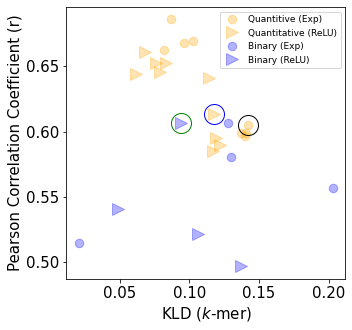

In [9]:

model_subset = [
    "binary_residual_binary",
    "new_models_CNN_1_task_ReLU",
    "new_models_CNN_1_all_Exp",
]

k1 = kld1_df

d1 = k1[k1["task_type"] == "quantitative"]
d2 = k1[k1["task_type"] == "binary"]

x1_exp = d1[d1["activation"] == "exp"].entropy.to_numpy()
y1_exp = d1[d1["activation"] == "exp"].pearson_corr.to_numpy()
x1_rel = d1[d1["activation"] == "relu"].entropy.to_numpy()
y1_rel = d1[d1["activation"] == "relu"].pearson_corr.to_numpy()


x2_exp = d2[d2["activation"] == "exp"].entropy.to_numpy()
y2_exp = d2[d2["activation"] == "exp"].pearson_corr.to_numpy()
x2_rel = d2[d2["activation"] == "relu"].entropy.to_numpy()
y2_rel = d2[d2["activation"] == "relu"].pearson_corr.to_numpy()

label_list = [
d1[d1["activation"] == "exp"]["model"].values.tolist(),
d1[d1["activation"] == "relu"]["model"].values.tolist(),
d2[d2["activation"] == "exp"]["model"].values.tolist(),
d2[d2["activation"] == "relu"]["model"].values.tolist()
]


model_labels = []
count = 0
for i in label_list:
    for j in i:
        model_labels += [j]
        count += 1
        
model_labels     




fig = plt.figure(figsize=(5,5))
ax = plt.subplot(1,1,1)

plt.plot(x1_exp, y1_exp, '.', color="orange", markersize=17, alpha=0.3)
plt.plot(x1_rel, y1_rel, '>', color="orange", markersize=12, alpha=0.3)

plt.plot(x2_exp, y2_exp, '.', color="blue", markersize=17, alpha=0.3)
plt.plot(x2_rel, y2_rel, '>', color="blue", markersize=12, alpha=0.3)


plt.ylabel('Pearson Correlation Coefficient (r)', fontsize=15)
plt.xlabel('KLD ($\it{k}$-mer)', fontsize=15)
plt.xticks([0., 0.05, 0.1, 0.15, 0.20], fontsize=15)
plt.yticks([0.5, 0.55, 0.6, 0.65, 0.7, 0.75], fontsize=15)
plt.legend(["Quantitive (Exp)", "Quantitative (ReLU)", "Binary (Exp)", "Binary (ReLU)"], fontsize=9, frameon=True, loc='upper right',) #bbox_to_anchor =(0., .0)


radius = 10
indicator_colors = ["black", "blue", "green"]
indicator_count = 0

count = 0
for z in ([zip(x1_exp,y1_exp), zip(x1_rel,y1_rel), zip(x2_exp, y2_exp), zip(x2_rel, y2_rel)]):

    for i, (x, y) in enumerate(z):

        idx = count

        label = model_labels[idx]

        if(label in model_subset):

            label = " ".join(label.split("_"))


            ax.plot(x, y, 'o', ms=radius * 2, mec=indicator_colors[indicator_count], mfc='none', mew=1)
            indicator_count += 1
                                                                   
        count += 1

# Plot Saliency Maps

In [10]:
cell_subset = ["GM12878"] 
cell_line = cell_subset[0]

model_subset = [
    "new_models_CNN_1_all_Exp",
    "new_models_CNN_1_task_ReLU",
    "binary_residual_binary",
]

model_name_list = []
attr_map_list = []
cell_line_dir = cell_line_dict[cell_subset[0]]
title_list = []

for i, model in enumerate(model_subset):
    a = df[df["model"] == model]
    b = kld1_df[kld1_df["model"] == model]
    for cell_line in cell_subset:
        a = a[a["cell_line"] == cell_line]
        model_name_list += [a.model.to_numpy()[0]]
        attr_map_list += [a.attr_map_path.to_numpy()[0]]
        title_list += [f"KLD:\n{b.entropy.to_numpy()[0]}"]

In [11]:
attr_map_0, X, _ = utils.load_data(attr_map_list[0], cell_line_dict[cell_subset[0]])
attr_map_1, X, _ = utils.load_data(attr_map_list[1], cell_line_dict[cell_subset[0]])
attr_map_2, X, _ = utils.load_data(attr_map_list[2], cell_line_dict[cell_subset[0]])

75


Text(0.5, 0, 'Positions')

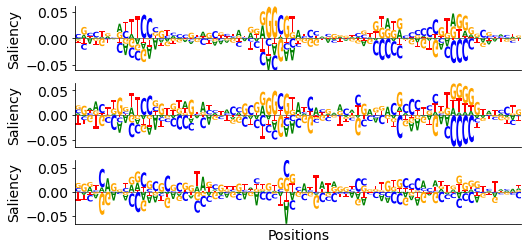

In [12]:
index = 1448

window = 50

start = 1150
end = 1225
print(end - start)
plot_range = range(start, end)

x = np.expand_dims(X[index], axis=0)
sal_scores_0 = np.expand_dims(attr_map_0[index], axis=0)
sal_scores_1 = np.expand_dims(attr_map_1[index], axis=0)
sal_scores_2 = np.expand_dims(attr_map_2[index], axis=0)

sal_scores_correct_0 = sal_scores_0 - np.mean(sal_scores_0, axis=2, keepdims=True)
sal_scores_correct_1 = sal_scores_1 - np.mean(sal_scores_1, axis=2, keepdims=True)
sal_scores_correct_2 = sal_scores_2 - np.mean(sal_scores_2, axis=2, keepdims=True)

saliency_df_0 = tfomics.impress.matrix_to_df(x, sal_scores_correct_0[0,plot_range,:])
saliency_df_1 = tfomics.impress.matrix_to_df(x, sal_scores_correct_1[0,plot_range,:])
saliency_df_2 = tfomics.impress.matrix_to_df(x, sal_scores_correct_2[0,plot_range,:])


fig = plt.figure(figsize=(8,4))
ax = plt.subplot(3,1,1)
utils.plot_attribution_map(saliency_df_0, ax, figsize=(20, 1), fontsize=14)
ax.set_ylabel('Saliency', fontsize=14)
plt.yticks([-0.05,0,.05])

ax = plt.subplot(3,1,2)
utils.plot_attribution_map(saliency_df_1, ax, figsize=(20, 1), fontsize=14)
ax.set_ylabel('Saliency', fontsize=14)
plt.yticks([-0.05,0,.05])

ax = plt.subplot(3,1,3)
utils.plot_attribution_map(saliency_df_2, ax, figsize=(20, 1), fontsize=14)
ax.set_ylabel('Saliency', fontsize=14)
plt.yticks([-0.05,0,.05])
ax.set_xlabel('Positions', fontsize=14)

75


Text(0.5, 0, 'Positions')

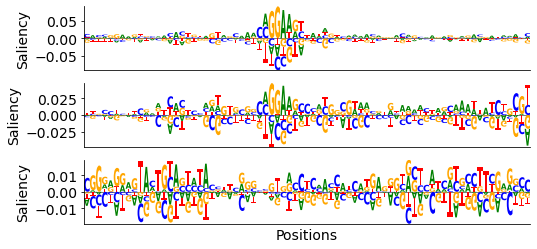

In [18]:
index = 257

window = 50

start = 624
end = 699
print(end - start)
plot_range = range(start, end)

x = np.expand_dims(X[index], axis=0)
sal_scores_0 = np.expand_dims(attr_map_0[index], axis=0)
sal_scores_1 = np.expand_dims(attr_map_1[index], axis=0)
sal_scores_2 = np.expand_dims(attr_map_2[index], axis=0)

sal_scores_correct_0 = sal_scores_0 - np.mean(sal_scores_0, axis=2, keepdims=True)
sal_scores_correct_1 = sal_scores_1 - np.mean(sal_scores_1, axis=2, keepdims=True)
sal_scores_correct_2 = sal_scores_2 - np.mean(sal_scores_2, axis=2, keepdims=True)


saliency_df_0 = tfomics.impress.matrix_to_df(x, sal_scores_correct_0[0,plot_range,:])
saliency_df_1 = tfomics.impress.matrix_to_df(x, sal_scores_correct_1[0,plot_range,:])
saliency_df_2 = tfomics.impress.matrix_to_df(x, sal_scores_correct_2[0,plot_range,:])


fig = plt.figure(figsize=(8,4))
ax = plt.subplot(3,1,1)
utils.plot_attribution_map(saliency_df_0, ax, figsize=(20, 1), fontsize=14)
ax.set_ylabel('Saliency', fontsize=14)

ax = plt.subplot(3,1,2)
utils.plot_attribution_map(saliency_df_1, ax, figsize=(20, 1), fontsize=14)
ax.set_ylabel('Saliency', fontsize=14)

ax = plt.subplot(3,1,3)
utils.plot_attribution_map(saliency_df_2, ax, figsize=(20, 1), fontsize=14)
ax.set_ylabel('Saliency', fontsize=14)
ax.set_xlabel('Positions', fontsize=14)

75


Text(0.5, 0, 'Positions')

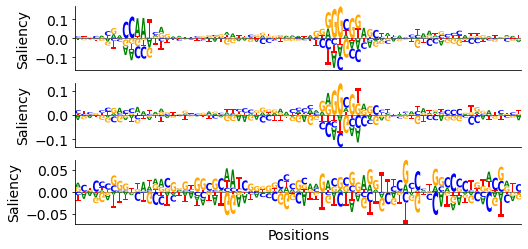

In [19]:
index = 1999

window = 50

start = 1150 - 50 + 20
end = start + 75
print(end - start)
plot_range = range(start, end)

x = np.expand_dims(X[index], axis=0)
sal_scores_0 = np.expand_dims(attr_map_0[index], axis=0)
sal_scores_1 = np.expand_dims(attr_map_1[index], axis=0)
sal_scores_2 = np.expand_dims(attr_map_2[index], axis=0)

sal_scores_correct_0 = sal_scores_0 - np.mean(sal_scores_0, axis=2, keepdims=True)
sal_scores_correct_1 = sal_scores_1 - np.mean(sal_scores_1, axis=2, keepdims=True)
sal_scores_correct_2 = sal_scores_2 - np.mean(sal_scores_2, axis=2, keepdims=True)

saliency_df_0 = tfomics.impress.matrix_to_df(x, sal_scores_correct_0[0,plot_range,:])
saliency_df_1 = tfomics.impress.matrix_to_df(x, sal_scores_correct_1[0,plot_range,:])
saliency_df_2 = tfomics.impress.matrix_to_df(x, sal_scores_correct_2[0,plot_range,:])


fig = plt.figure(figsize=(8,4))
ax = plt.subplot(3,1,1)
utils.plot_attribution_map(saliency_df_0, ax, figsize=(20, 1), fontsize=14)
ax.set_ylabel('Saliency', fontsize=14)

ax = plt.subplot(3,1,2)
utils.plot_attribution_map(saliency_df_1, ax, figsize=(20, 1), fontsize=14)
ax.set_ylabel('Saliency', fontsize=14)

ax = plt.subplot(3,1,3)
utils.plot_attribution_map(saliency_df_2, ax, figsize=(20, 1), fontsize=14)
ax.set_ylabel('Saliency', fontsize=14)
ax.set_xlabel('Positions', fontsize=14)

75


Text(0.5, 0, 'Positions')

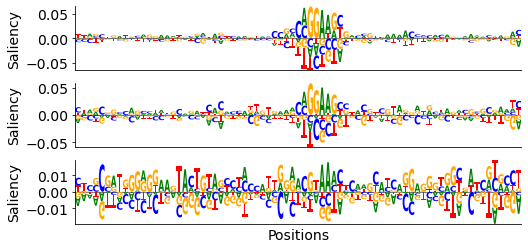

In [20]:
index = 258

window = 50

start = 625
end = start + 75
print(end - start)
plot_range = range(start, end)

x = np.expand_dims(X[index], axis=0)
sal_scores_0 = np.expand_dims(attr_map_0[index], axis=0)
sal_scores_1 = np.expand_dims(attr_map_1[index], axis=0)
sal_scores_2 = np.expand_dims(attr_map_2[index], axis=0)

sal_scores_correct_0 = sal_scores_0 - np.mean(sal_scores_0, axis=2, keepdims=True)
sal_scores_correct_1 = sal_scores_1 - np.mean(sal_scores_1, axis=2, keepdims=True)
sal_scores_correct_2 = sal_scores_2 - np.mean(sal_scores_2, axis=2, keepdims=True)


saliency_df_0 = tfomics.impress.matrix_to_df(x, sal_scores_correct_0[0,plot_range,:])
saliency_df_1 = tfomics.impress.matrix_to_df(x, sal_scores_correct_1[0,plot_range,:])
saliency_df_2 = tfomics.impress.matrix_to_df(x, sal_scores_correct_2[0,plot_range,:])


fig = plt.figure(figsize=(8,4))
ax = plt.subplot(3,1,1)
utils.plot_attribution_map(saliency_df_0, ax, figsize=(20, 1), fontsize=14)
ax.set_ylabel('Saliency', fontsize=14)


ax = plt.subplot(3,1,2)
utils.plot_attribution_map(saliency_df_1, ax, figsize=(20, 1), fontsize=14)
ax.set_ylabel('Saliency', fontsize=14)


ax = plt.subplot(3,1,3)
utils.plot_attribution_map(saliency_df_2, ax, figsize=(20, 1), fontsize=14)
ax.set_ylabel('Saliency', fontsize=14)
ax.set_xlabel('Positions', fontsize=14)

# Synthetic

In [13]:
def my_func_entropy_synthetic(model_and_attr_map):
    
    
    data = {
        "entropy": [],
        "auroc": [],
        "snr": [],
        "lr_type": [],
        "bn": [],
        "activation": [],
        "method": [],
        "trial": [],
        "path": [],
        "kmer_length": []
    }



    lr_type, bn, activation, method, attr_type, trial, out_path, path, attribution_map, auroc, snr, kmer_length = model_and_attr_map
    threshold = 0.9

    # load test set
    _, _, _, X, X_model = utils.get_dataset()

    
    seq_list, cutoff_array = utils.collect_passing_subsequences(attribution_map, X, threshold=threshold, kmer_length=kmer_length)
    
    kmer_path = f"../data/synthetic/kmer_prior"
    with FileLock(os.path.expanduser(f"{kmer_path}/kmer_prior.h5.lock")):
        with h5py.File(f"{kmer_path}/kmer_prior.h5", "r") as f:
            kmer_prior = f[f"{kmer_length}"][:]

    entropy, obj, global_counts_normalized, kmer_prior, kmer_dict = utils.calculate_kmer_entropy(X, seq_list, kmer_prior=kmer_prior, kmer_length=kmer_length)

    data["entropy"] += [entropy]
    data["auroc"] += [auroc]
    
    
    # add the corresponding pearson correlation here as well

    data["lr_type"] += [lr_type]
    data["activation"] += [activation]
    data["method"] += [method]
    data["trial"] += [trial]
    data["bn"] += [bn]
    data["snr"] += [snr]
    data["path"] += [path]
    data["kmer_length"] += [kmer_length]
    
    
    

    pd.DataFrame(data).to_csv(f"{out_path}/entropy_results_{kmer_length}.csv", index=None)

In [14]:
# Create list of arguments to pass through function
out_dir = "../results/synthetic/method_1"
synthetic_path = "../data/synthetic/synthetic_data.h5"

kmer_length = 6
synthetic_args = []

with h5py.File(synthetic_path, 'r') as f:
    
    for grp_name in f.keys():
        
        attr_map = f[grp_name]["attr_map"][:]
        auroc = f[grp_name]["auroc"][()]
        snr = f[grp_name]["snr"][()]
        path = f[grp_name]["path"][()].decode('UTF-8')

        lr_type, bn, activation, method, attr_type, trial = path.split('/')[1:]
        trial = int(trial)
        out_path = f"{out_dir}{path}"
        Path(f"{out_path}").mkdir(parents=True, exist_ok=True)
        
        synthetic_args += [(lr_type, bn, activation, method, attr_type, trial, out_path, path, attr_map, auroc, snr, kmer_length)]

In [15]:
# Test for a single argument
my_func_entropy_synthetic(synthetic_args[0])

In [16]:
# Run for all args
utils.run_pool(my_func_entropy_synthetic, synthetic_args, 20)

Running function using 20 workers


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 327/327 [00:20<00:00, 15.61it/s]


Time taken: 21.65 seconds!


# Evaluate

In [17]:
data = []


for arg in synthetic_args:
    
    lr_type, bn, activation, method, attr_type, trial, out_path, path, attr_map, auroc, snr, kmer_length = arg
    
    frame = pd.read_csv(f"{out_path}/entropy_results_{kmer_length}.csv")

    data += [frame]


    
entropy_df = pd.concat(data, axis=0)    
entropy_df["index"] = range(len(entropy_df))

entropy_df


,entropy,auroc,snr,lr_type,bn,activation,method,trial,path,kmer_length,index
0,0.106,0.973462,1.315170,fixedlr,bn,exponential,adversarial,1,/fixedlr/bn/exponential/adversarial/saliency/1,6,0
0,0.100,0.971930,1.570055,fixedlr,bn,exponential,adversarial,10,/fixedlr/bn/exponential/adversarial/saliency/10,6,1
0,1.543,0.978952,6.810561,fixedlr,bn,exponential,gn,0,/fixedlr/bn/exponential/gn/saliency/0,6,2
0,1.104,0.978991,1.797297,fixedlr,bn,relu,manifold-gn,2,/fixedlr/bn/relu/manifold-gn/saliency/2,6,3
0,0.958,0.984649,0.140598,fixedlr,bn,relu,manifold-gn,3,/fixedlr/bn/relu/manifold-gn/saliency/3,6,4
...,...,...,...,...,...,...,...,...,...,...,...
0,0.766,0.974185,0.535987,fixedlr,bn,relu,gn,7,/fixedlr/bn/relu/gn/saliency/7,6,322
0,0.471,0.975217,0.397261,fixedlr,bn,relu,gn,8,/fixedlr/bn/relu/gn/saliency/8,6,323
0,0.511,0.976608,0.471243,fixedlr,bn,relu,gn,9,/fixedlr/bn/relu/gn/saliency/9,6,324
0,1.061,0.976566,1.755213,fixedlr,bn,relu,manifold-gn,0,/fixedlr/bn/relu/manifold-gn/saliency/0,6,325


In [18]:
# identify indices of subselected models
lower_bound = "/fixedlr/nobn/relu/gn/saliency/12"
upper_bound = "/fixedlr/bn/exponential/manifold-mixup/saliency/2"
sub_models = [lower_bound, upper_bound]
entropy_df[entropy_df["path"].isin(sub_models)]

,entropy,auroc,snr,lr_type,bn,activation,method,trial,path,kmer_length,index
0,0.127,0.98590,0.568456,fixedlr,nobn,relu,gn,12,/fixedlr/nobn/relu/gn/saliency/12,6,166
0,1.412,0.98666,4.142531,fixedlr,bn,exponential,manifold-mixup,2,/fixedlr/bn/exponential/manifold-mixup/saliency/2,6,266


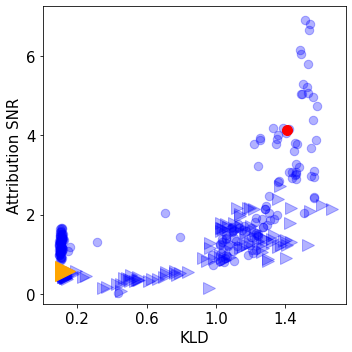

In [19]:
# Plot scatterplots

REGULARIZERS = [
    'standard',
    'mixup',
    'manifold-mixup',
    'gn',
    'manifold-gn',
    'sn',
    'adversarial',
]

reg_dict = {
    'standard': "Standard",
    'mixup': "Mixup",
    'manifold-mixup': "Manifold-mixup",
    'gn': "Noise",
    'manifold-gn': "Manifold-noise",
    'sn': "Spectral-norm",
    'adversarial': "Adversarial",
}

ACTIVATIONS = ['relu','exponential']
BN = ['bn', 'nobn']
SCHEDULE = ['fixedlr'] 



fig = plt.figure(figsize=(5,5))
ax = plt.subplot(1,1,1)


for k, lr_type in enumerate(SCHEDULE):

    res = entropy_df[entropy_df["lr_type"] == lr_type]

    for i, regularizer in enumerate(REGULARIZERS):

        r1 = res[res["method"] == regularizer]

        for j, bn in enumerate(BN):

            d1 = r1[r1["bn"] == bn]


            x1_exp = d1[d1["activation"] == "exponential"].entropy.to_numpy()
            y1_exp = d1[d1["activation"] == "exponential"].snr.to_numpy()
            x1_rel = d1[d1["activation"] == "relu"].entropy.to_numpy()
            y1_rel = d1[d1["activation"] == "relu"].snr.to_numpy()
            
            
            if ((k == 0) and (j == 0)):
                label = reg_dict[regularizer]
            else:
                label = None


            plt.plot(x1_exp, y1_exp, '.', color="blue", label=None, markersize=17, alpha=0.3)
            plt.plot(x1_rel, y1_rel, '>', color="blue", label=None, markersize=12, alpha=0.3)
            

x = entropy_df[entropy_df["index"] == 266].entropy.to_numpy()
y = entropy_df[entropy_df["index"] == 266].snr.to_numpy()
plt.plot(x, y, '.', color="red", label=None, markersize=20, alpha=1) #alpha=0.5



x = entropy_df[entropy_df["index"] == 166].entropy.to_numpy()
y = entropy_df[entropy_df["index"] == 166].snr.to_numpy()
plt.plot(x, y, '>', color="orange", label=None, markersize=20, alpha=1) #alpha=0.5


ax.set_xlabel("KLD", fontsize=15)
ax.set_ylabel("Attribution SNR", fontsize=15)
ax.set_ylim([0-0.25, 7.+0.25])
plt.yticks([0, 2, 4, 6], fontsize=15)
ax.set_xlim([0.2-0.2, 1.6 + 0.15])
plt.xticks([0.2, 0.6, 1.0, 1.4],fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout();  

plt.show()

In [20]:
pearsonr(entropy_df["snr"].to_numpy(), entropy_df["entropy"].to_numpy())

(0.6177498655017052, 8.556890895297187e-36)

0


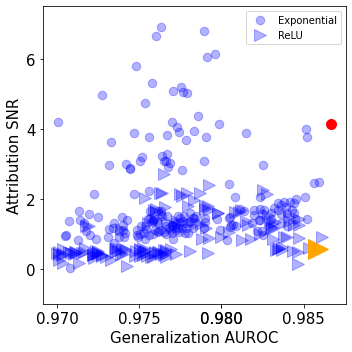

In [21]:
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(1,1,1)
count = 0

for k, lr_type in enumerate(SCHEDULE):

    res = entropy_df[entropy_df["lr_type"] == lr_type]

    for i, regularizer in enumerate(REGULARIZERS):

        r1 = res[res["method"] == regularizer]

        for j, bn in enumerate(BN):

            d1 = r1[r1["bn"] == bn]


            x1_exp = d1[d1["activation"] == "exponential"].auroc.to_numpy()
            y1_exp = d1[d1["activation"] == "exponential"].snr.to_numpy()
            x1_rel = d1[d1["activation"] == "relu"].auroc.to_numpy()
            y1_rel = d1[d1["activation"] == "relu"].snr.to_numpy()
            
            if(count < 1):
                print(count)
                label1 = "Exponential"
                label2 = "ReLU"
            else:
                label1 = None
                label2 = None
                
            count += 1
            

            plt.plot(x1_exp, y1_exp, '.', color="blue", label=label1, markersize=17, alpha=0.3)
            plt.plot(x1_rel, y1_rel, '>', color="blue", label=label2, markersize=12, alpha=0.3)
            count += 1
            

x = entropy_df[entropy_df["index"] == 266].auroc.to_numpy()
y = entropy_df[entropy_df["index"] == 266].snr.to_numpy()
plt.plot(x, y, '.', color="red", label=None, markersize=20, alpha=1) 




x = entropy_df[entropy_df["index"] == 166].auroc.to_numpy()
y = entropy_df[entropy_df["index"] == 166].snr.to_numpy()
plt.plot(x, y, '>', color="orange", label=None, markersize=20, alpha=1) 



ax.set_xlabel("Generalization AUROC", fontsize=15)
ax.set_ylabel("Attribution SNR", fontsize=15)

plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

ax.legend(fontsize=10, loc='upper right') 
ax.set_xlim([0.970027-0.0009, 0.986660+0.0009])
plt.xticks([0.97, 0.975, 0.98, 0.98, 0.985], fontsize=15)
ax.set_ylim([-1, 7.5])
plt.yticks([0, 2, 4, 6], fontsize=15)
plt.tight_layout();  

plt.show()

# Plot synthetic saliency maps

In [22]:
# Create list of arguments to pass through function
out_dir = "../results/synthetic/method_1"

synthetic_path = "../data/synthetic/synthetic_data.h5"

attr_map_path_1 = "/fixedlr/bn/exponential/manifold-mixup/saliency/2"
attr_map_path_2 = "/fixedlr/nobn/relu/gn/saliency/12"


with h5py.File(synthetic_path, 'r') as f:
    
    for grp_name in f.keys():
        
        
        
        attr_map = f[grp_name]["attr_map"][:]
        auroc = f[grp_name]["auroc"][()]
        snr = f[grp_name]["snr"][()]
        path = f[grp_name]["path"][()].decode('UTF-8')
        if(path in [attr_map_path_1, attr_map_path_2]):
            print(grp_name, path)


248 /fixedlr/nobn/relu/gn/saliency/12
44 /fixedlr/bn/exponential/manifold-mixup/saliency/2


In [23]:
with h5py.File(synthetic_path, 'r') as f:

    attr_map_1 = f["44"]["attr_map"][:]
    attr_map_2 = f["248"]["attr_map"][:]

# Load testset data and ground truth
_, _, _, X, X_model = utils.get_dataset()

X_model = X_model - 0.25

75


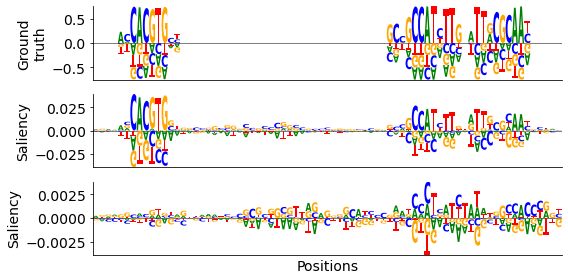

In [24]:
index = 0



start = 0
end = 75
print(end - start)
plot_range = range(start, end)

x = np.expand_dims(X[index], axis=0)
sal_scores_1 = np.expand_dims(attr_map_1[index], axis=0)
sal_scores_2 = np.expand_dims(attr_map_2[index], axis=0)
model_scores = np.expand_dims(X_model[index], axis=0)

sal_scores_correct_1 = sal_scores_1 - np.mean(sal_scores_1, axis=2, keepdims=True)
sal_scores_correct_2 = sal_scores_2 - np.mean(sal_scores_2, axis=2, keepdims=True)

saliency_df_1 = tfomics.impress.matrix_to_df(x, sal_scores_correct_1[0,plot_range,:])
saliency_df_2 = tfomics.impress.matrix_to_df(x, sal_scores_correct_2[0,plot_range,:])
model_df = tfomics.impress.matrix_to_df(x, model_scores[0,plot_range,:])


fig = plt.figure(figsize=(8,4))

ax = plt.subplot(3,1,1)
utils.plot_attribution_map(model_df, ax, figsize=(20, 1), fontsize=14)
ax.set_ylabel('Ground\ntruth', fontsize=14)

ax = plt.subplot(3,1,2)
utils.plot_attribution_map(saliency_df_1, ax, figsize=(20, 1), fontsize=14)
ax.set_ylabel('Saliency', fontsize=14)

ax = plt.subplot(3,1,3)
utils.plot_attribution_map(saliency_df_2, ax, figsize=(20, 1), fontsize=14)
ax.set_ylabel('Saliency', fontsize=14)

ax.set_xlabel('Positions', fontsize=14)

plt.tight_layout()

# Plot k-mer spectra

In [25]:
# Load genomic prior
prior_path = "../data/synthetic/kmer_prior/kmer_prior.h5"
with h5py.File(prior_path, "r") as f:
    prior = f[f"{kmer_length}"][:]

seq_list, cutoff_array = utils.collect_passing_subsequences(attr_map=attr_map_1, X=X)
entropy, obj, freq_1, prior, kmer_dict = utils.calculate_kmer_entropy(X, seq_list, kmer_prior=prior, kmer_length=kmer_length)        


seq_list, cutoff_array = utils.collect_passing_subsequences(attr_map=attr_map_2, X=X)
entropy, obj, freq_2, prior, kmer_dict = utils.calculate_kmer_entropy(X, seq_list, kmer_prior=prior, kmer_length=kmer_length)        

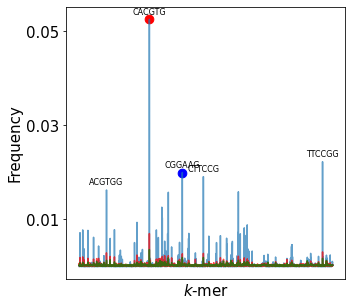

In [26]:
xs = np.arange(obj.n)
ys = freq_1

fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1,1,1)

plt.plot(freq_1, alpha=0.7)
plt.plot(freq_2, c="r", alpha=.7)
plt.plot(prior, c="g", alpha=.7)


plt.ylabel('Frequency', fontsize=15)
plt.xlabel('$\it{k}$-mer', fontsize=15)

ax.set_xticks([])

ax.set_yticks([0.01, 0.03, 0.05])
ax.set_yticklabels([0.01, 0.03, 0.05], size=15)
annotations = ["CACGTG", "CGGAAG"]
colors = ["red", "blue"]


# plot annotations
t = ys[np.argsort(ys)[::-1][5]]


for i, (x,y) in enumerate(zip(xs,ys)):

    if (y > t):
        label = kmer_dict[i]

        for j, annotation in enumerate(annotations):
            if(annotation in label):
                
                plt.scatter(x, y, c=colors[j], s=75, alpha=1.)

        plt.annotate(label, 
                     (x,y),
                     textcoords="offset points", size=8,
                     xytext=(0,5), 
                     ha='center')